In [1]:
import torch
import torch.nn as nn
from torch_geometric.datasets import QM7b
from torch_geometric.utils import to_networkx
import networkx as nx
import numpy as np
import torch.optim as optim
import random
import torch.nn.functional as F
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
import torch_geometric.nn as tgnn
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax

import sys
sys.path.append('..')
import functions.edge_index_functions as edge_index_functions
import functions.overall_functions as overall_functions
import importlib
importlib.reload(overall_functions)
import matplotlib.pyplot as plt
import regression
from torchmetrics.regression import MeanAbsoluteError, R2Score, MeanSquaredError
import copy
from sklearn.preprocessing import StandardScaler, Normalizer

In [2]:
overall_functions.set_all_seeds(42)

In [3]:
dataset = QM7b('data', pre_transform=T.NormalizeFeatures())
dataset

c:\Users\szige\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) 

QM7b(7211)

In [4]:
diameters = overall_functions.get_diameters(dataset)
torch.max(diameters)

tensor(1.)

In [5]:
num_nodes = [x.num_nodes for x in dataset]
max_nodes = np.max(num_nodes)
in_features = 2
X = regression.create_node_features(len(dataset),num_nodes, max_nodes, in_features)
# y = torch.cat([x.y for x in dataset]).to(torch.float)
labels = np.vstack([data.y.numpy() for data in dataset])
scaler = StandardScaler()
scaler.fit(labels)
y = torch.tensor(scaler.transform(labels))
edge_indices =[x.edge_index for x in dataset]

In [6]:
class GNN(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(GNN, self).__init__()
        self.pre_mlp = nn.Linear(in_features, 16)
        self.layernorm1 = nn.LayerNorm(16)
        self.layer1 = edge_index_functions.GraphAttentionLayer(16, 32, 4, 0.2, 0.2)
        self.layernorm2 = nn.LayerNorm(32)
        self.layer2 = edge_index_functions.GraphAttentionLayer(32, 32, 4, 0.2, 0.2)
        self.layernorm3 = nn.LayerNorm(32)
        self.linear = nn.Linear(32, out_features)
        self.skip_connection = nn.Linear(16, 32)

        
    def forward(self, features: torch.Tensor, edge_index: torch.Tensor, indices:torch.Tensor):
        features = self.pre_mlp(features)
        features = self.layernorm1(features)
        features = torch.relu(features)

        features_skip = self.skip_connection(features)
        features = self.layer1(features, edge_index)
        features = self.layernorm2(features)
        features = torch.relu(features + features_skip)

        features_skip = features
        features = self.layer2(features, edge_index)
        features = self.layernorm3(features)
        features = torch.relu(features + features_skip)

        readout = self.pooling(features, indices)
        readout = self.linear(readout)
        return readout        

    def pooling(self, features: torch.Tensor, indices: torch.Tensor):
        graph_embedding = torch.zeros(indices.max().item() + 1, features.size(1))
        graph_embedding = graph_embedding.index_add(0, indices, features)
        count = torch.bincount(indices)
        graph_embedding = graph_embedding / count.unsqueeze(1)
        return graph_embedding

In [7]:
train_indices, val_indices, test_indices = overall_functions.get_indices(len(dataset), 0.8, 0.1)
len(train_indices), len(val_indices), len(test_indices)

(5768, 721, 722)

In [8]:
batch_size = 16
X_train, y_train, edge_train, indices_train = edge_index_functions.get_batched_data([X[i] for i in train_indices], y[train_indices], [edge_indices[i] for i in train_indices], batch_size)
X_val, y_val, edge_val, indices_val = edge_index_functions.get_batched_data([X[i] for i in val_indices], y[val_indices], [edge_indices[i] for i in val_indices], batch_size)
X_test, y_test, edge_test, indices_test = edge_index_functions.get_batched_data([X[i] for i in test_indices], y[test_indices], [edge_indices[i] for i in test_indices], batch_size)

len(X_train), len(y_train), len(edge_train), len(indices_train), len(X_val), len(y_val), len(edge_val), len(indices_val), len(X_test), len(y_test), len(edge_test), len(indices_test)

(361, 361, 361, 361, 46, 46, 46, 46, 46, 46, 46, 46)

In [9]:
in_features = X[0].shape[-1]
out_features = dataset[0].y.shape[1]
model = GNN(in_features, out_features)

In [10]:
num_epochs = 30
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()
best_state_dict = None
patience = 5
metrics_tracker = regression.MetricsTracker(loss_fn, patience)
regression.fit(model, optimizer, metrics_tracker, num_epochs, X_train, edge_train, indices_train, y_train, X_val, edge_val, indices_val, y_val)

Epoch: 0 | Train Loss: 0.855208 | Val Loss: 0.728690
Epoch: 1 | Train Loss: 0.749869 | Val Loss: 0.722808
Epoch: 2 | Train Loss: 0.747436 | Val Loss: 0.721552
Epoch: 3 | Train Loss: 0.745928 | Val Loss: 0.720148
Epoch: 4 | Train Loss: 0.744056 | Val Loss: 0.717505
Epoch: 5 | Train Loss: 0.741746 | Val Loss: 0.715118
Epoch: 6 | Train Loss: 0.739946 | Val Loss: 0.714050
Epoch: 7 | Train Loss: 0.738591 | Val Loss: 0.713369
Epoch: 8 | Train Loss: 0.737450 | Val Loss: 0.713030
Epoch: 9 | Train Loss: 0.736511 | Val Loss: 0.712676
Epoch: 10 | Train Loss: 0.735484 | Val Loss: 0.712487
Epoch: 11 | Train Loss: 0.734715 | Val Loss: 0.712169
Epoch: 12 | Train Loss: 0.733829 | Val Loss: 0.711833
Epoch: 13 | Train Loss: 0.733126 | Val Loss: 0.711409
Epoch: 14 | Train Loss: 0.732462 | Val Loss: 0.711223
Epoch: 15 | Train Loss: 0.731740 | Val Loss: 0.710994
Epoch: 16 | Train Loss: 0.731171 | Val Loss: 0.710707
Epoch: 17 | Train Loss: 0.730481 | Val Loss: 0.710351
Epoch: 18 | Train Loss: 0.729923 | Val

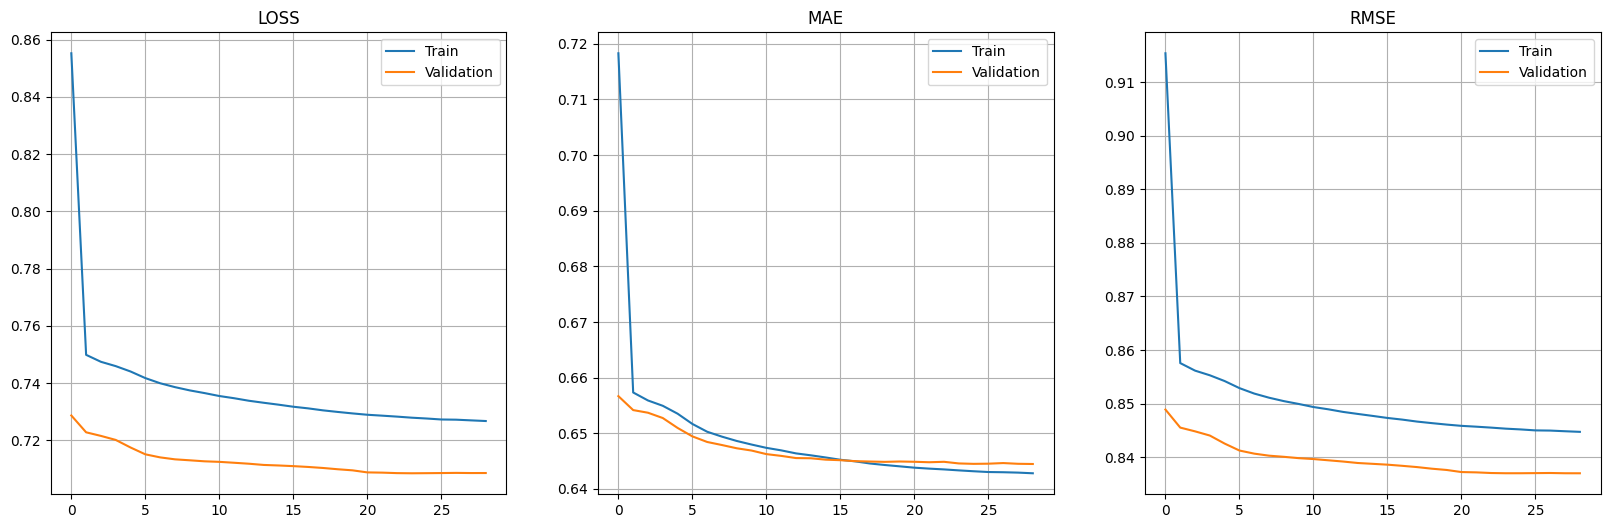

In [11]:
metrics_tracker.plot_history()

In [12]:
test_logits, test_labels = overall_functions.get_test(model, X_test, edge_test, indices_test, y_test)
metrics_tracker.get_metrics(test_logits, test_labels)

(tensor(0.7360), tensor(0.6425), tensor(0.8579))

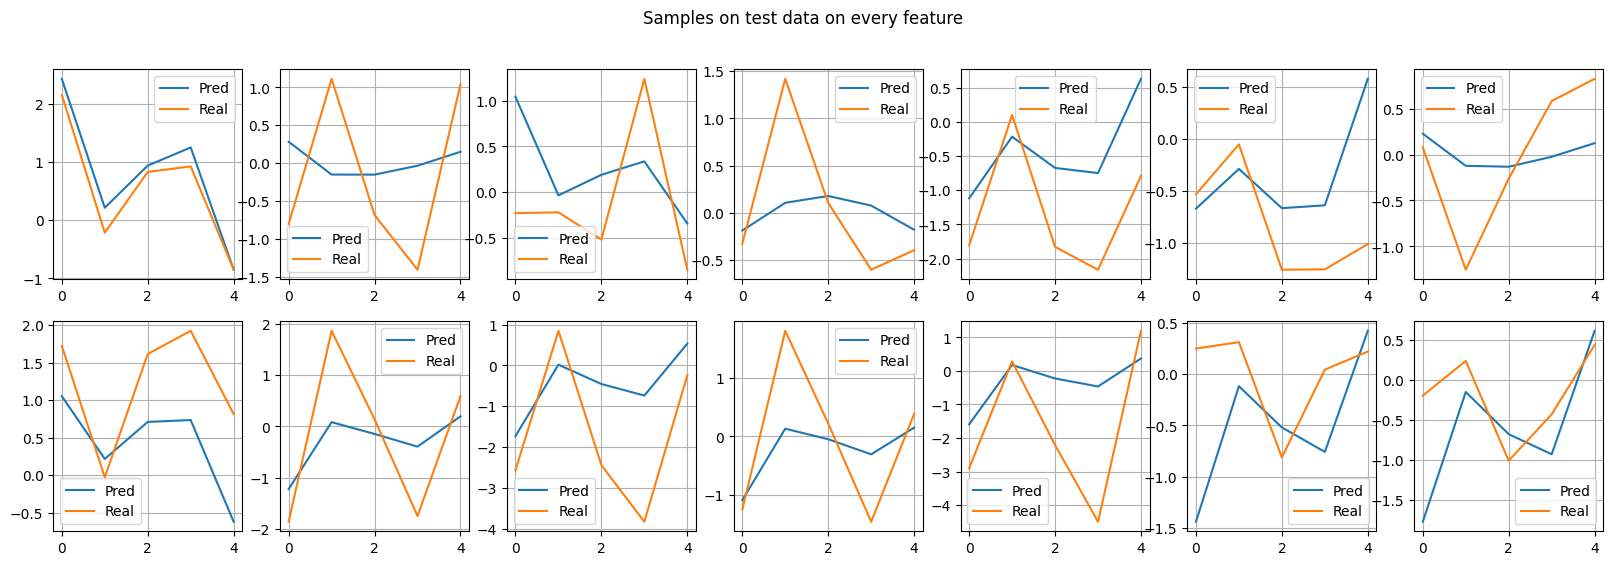

In [13]:
regression.plot_tests(test_logits, test_labels)